In [21]:
%matplotlib inline
import pandas as pd
import os
from datetime import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
from gpflow.utilities import print_summary
gpflow.config.set_default_summary_fmt("notebook")

# plotly viz - use matplotlib if you prefer
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# cleanair modules
from cleanair.scoot import ScootQuery

In [22]:
secretfile = "../../terraform/.secrets/db_secrets.json"

# choose a start and end date for this query
start_datetime="2020-03-23 00:00:00"
end_datetime="2020-03-25 00:00:00"

# columns to analyse
columns = ["n_vehicles_in_interval", "occupancy_percentage", "congestion_percentage", "saturation"]

SQ = ScootQuery(secretfile=secretfile)

2020-03-27 15:57:02     INFO: Database connection information loaded from <_io.TextIOWrapper name='../../terraform/.secrets/db_secrets.json' mode='r' encoding='UTF-8'>


# Detector readings
Get all scoot observations between `start_datetime` and `end_datetime`

In [23]:
all_df = SQ.get_all_readings(start_datetime=start_datetime, end_datetime=end_datetime)

In [24]:
all_df.columns

Index(['detector_id', 'lon', 'lat', 'measurement_start_utc',
       'measurement_end_utc', 'n_vehicles_in_interval', 'occupancy_percentage',
       'congestion_percentage', 'saturation'],
      dtype='object')

# Simple Data cleaning

    - Convert Datetime to epoch
    - Add normalised/standardised columns

In [25]:
def normalise(x):
    """Standardize all columns individually"""
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def denormalise(x, wrt_y):
    """Denormalize x given the original data it was standardized to"""
    return ( x * np.std(wrt_y, axis=0) ) + np.mean(wrt_y, axis=0)

In [26]:
all_df['measurement_start_utc'] = pd.to_datetime(all_df['measurement_start_utc'])
all_df['epoch'] = all_df['measurement_start_utc'].astype('int64')//1e9 #convert to epoch

all_df['epoch_norm'] = normalise(all_df['epoch'])
all_df['lat_norm'] = normalise(all_df['lat'])
all_df['lon_norm'] = normalise(all_df['lon'])

# Helper functions

In [27]:
def get_X(df):
    return np.array(df[['epoch_norm', 'lon_norm', 'lat_norm']])

def get_Y(df):
    return np.array(df[['n_vehicles_in_interval']])

# Jointly train all sensors

The input $X$ is time epoch, lat, lon and output $Y$ is the integer n_vehicles_in_interval

NOTE for 2 days of scoot data there are approx 400000 observations

In [28]:
X = get_X(all_df) # N x D
Y = get_Y(all_df) # N x 1

In [29]:
print(Y.shape)

(477410, 1)


&lt; insert model here &gt;

# Train scoot individually as a time series

In [30]:
scoot_ids = np.unique(all_df['detector_id'])
grouped_df = all_df.groupby('detector_id')

In [31]:
scoot_individual_df_arr = [grouped_df.get_group(scoot_id) for scoot_id in scoot_ids] #array of dfs for all sensors
X_arr = [get_X(df) for df in scoot_individual_df_arr] # |Number of scoot sensors| x N_i x D
Y_arr = [get_Y(df) for df in scoot_individual_df_arr] # |Number of scoot sensors| x N_i x 1

&lt; insert model here &gt;

## Simple Time series plot

In [207]:
color_counts = 'C0'
label_counts = 'N'
color_estimated_counts = 'red'
label_estimated_counts = '$\hat{N}$'

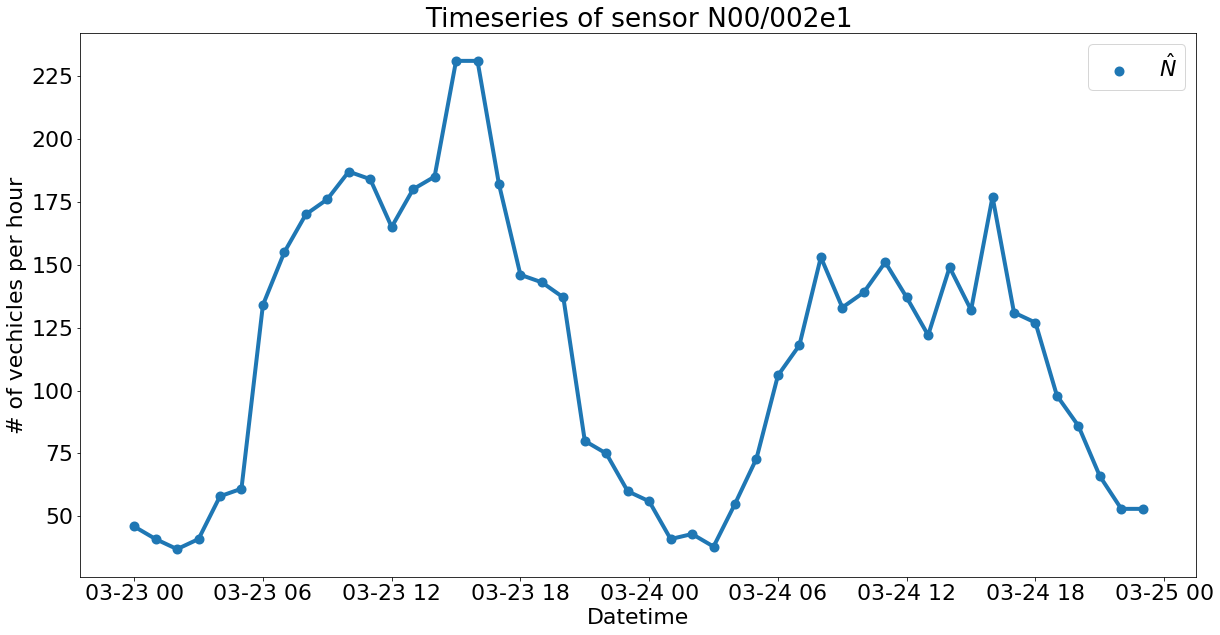

In [200]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
scoot_id = 0
sensor_df = scoot_individual_df_arr[scoot_id]
plt.plot(sensor_df['measurement_start_utc'], sensor_df['n_vehicles_in_interval'], linewidth=4)
plt.scatter(sensor_df['measurement_start_utc'], sensor_df['n_vehicles_in_interval'], linewidth=4, 
            color = color_counts, label = label_counts)
plt.title('Timeseries of sensor {scoot_id}'.format(scoot_id=scoot_ids[scoot_id]))
plt.xlabel('Datetime')
plt.ylabel('# of vechicles per hour')
plt.legend()
plt.show()

# Fit LGCP model for each sensor

In [233]:
## Set random seed
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

In [234]:
## Optimization functions - train the model for the given epochs
def optimization_step(model: gpflow.models.SVGP, X, Y):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        obj = -model.elbo(X, Y)
        grads = tape.gradient(obj, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
def simple_training_loop(X, Y, model: gpflow.models.SVGP, epochs: int = 1, logging_epoch_freq: int = 10):
    tf_optimization_step = tf.function(optimization_step)
    for epoch in range(epochs):
        for _ in range(num_batches_per_epoch):
            tf_optimization_step(model, X, Y)

        epoch_id = epoch + 1
        if epoch_id % logging_epoch_freq == 0:
            tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(X,Y)}")

In [269]:
## Given the data and the specific sensor this function optimise the ELBO and plot the results 
def train_sensor_model(scoot_id, X_arr, Y_arr, epochs = 100, logging_epoch_freq = 10, plot=True):
    ## To remove newaxis when more features
    num_features = X_arr[scoot_id][:,0][:,np.newaxis].shape[0]
    
    X = tf.convert_to_tensor(X_arr[scoot_id][:,0][:,np.newaxis])
    Y = tf.convert_to_tensor(Y_arr[scoot_id].astype(np.float64))
    
    ## To pass it as a function arg
    k = gpflow.kernels.Periodic(0.6)
    
    lik = gpflow.likelihoods.Poisson()
    
    ## Add code for inducing inputs - Needed when we run on the full data
    model = gpflow.models.SVGP(kernel = k, likelihood=lik, inducing_variable=X)
    
    ## Uncomment to see which variables are training and those that are not
    #print_summary(model)
    
    simple_training_loop(X, Y, model, epochs = epochs, 
                         logging_epoch_freq = logging_epoch_freq)
    
    if plot == True:
        plot_results(scoot_individual_df_arr, sensor_df, model, X)
    return model

In [270]:
## Given the trained model this function samples from the posterior intensity and then samples from the Poisson
## to get estimated mean and variance for the counts 
def sample_N(model, test_inputs, num_samples=10):
    samples = np.random.poisson(np.exp(model.predict_f_samples(test_inputs,num_samples)))
    samples_mean = np.mean(samplesN,axis=0)
    samples_var = np.var(samplesN,axis=0)
    
    return samples_mean, samples_var

In [271]:
## This functions plot the results together with the true counts
def plot_results(scoot_individual_df_arr, sensor_df, model, test_inputs):
    mean_N, var_N = sample_N(model, test_inputs, num_samples=10)
    
    plt.rcParams.update({'font.size': 22})
    plt.figure(figsize=(20, 10))
    scoot_id = 0
    sensor_df = scoot_individual_df_arr[scoot_id]
    plt.plot(sensor_df['measurement_start_utc'], sensor_df['n_vehicles_in_interval'], linewidth=4)
    plt.scatter(sensor_df['measurement_start_utc'], sensor_df['n_vehicles_in_interval'], linewidth=4, 
                    color = color_counts, label = label_counts)
        
    plt.plot(sensor_df['measurement_start_utc'], averages_N,color = color_estimated_counts)
        
    plt.scatter(sensor_df['measurement_start_utc'], averages_N, color = color_estimated_counts, 
                    label = label_estimated_counts)
    plt.fill_between(sensor_df['measurement_start_utc'], 
                     mean_N[:,0] - np.sqrt(var_N)[:,0], 
                     mean_N[:,0] + np.sqrt(var_N)[:,0], 
                     facecolor= color_estimated_counts, alpha=0.4)
    plt.fill_between(sensor_df['measurement_start_utc'], 
                     mean_N[:,0] - 2*np.sqrt(var_N)[:,0], 
                     mean_N[:,0] + 2*np.sqrt(var_N)[:,0], 
                     facecolor= color_estimated_counts, alpha=0.3)
    plt.fill_between(sensor_df['measurement_start_utc'], 
                     mean_N[:,0] - 3*np.sqrt(var_N)[:,0], 
                     mean_N[:,0] + 3*np.sqrt(var_N)[:,0], 
                     facecolor= color_estimated_counts, alpha=0.2)
    plt.title('Timeseries of sensor {scoot_id}'.format(scoot_id=scoot_ids[scoot_id]))
    plt.xlabel('Datetime')
    plt.ylabel('# of vechicles per hour')
    plt.legend()
    plt.show()

Epoch 500: ELBO (train) -1435.5658568234098
Epoch 1000: ELBO (train) -859.8855074087447
Epoch 1500: ELBO (train) -783.6987443501715
Epoch 2000: ELBO (train) -484.0499814426736


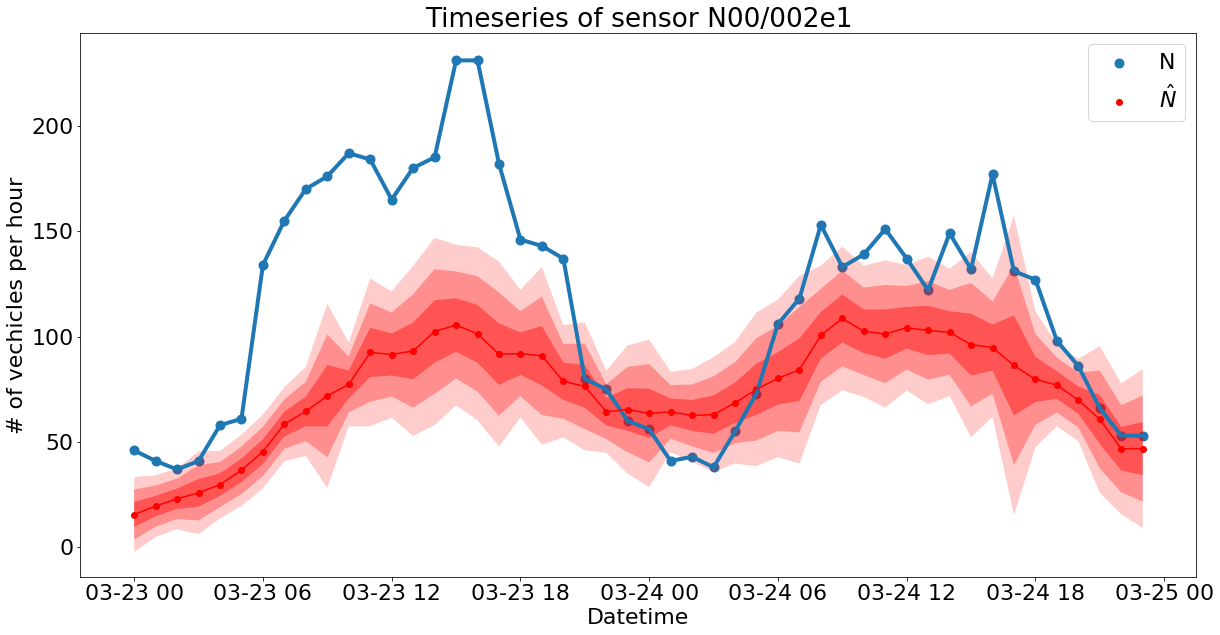

In [273]:
scoot_id = 3
epochs = 2000
logging_epoch_freq = 500
new_model = train_sensor_model(scoot_id, X_arr, Y_arr, epochs, logging_epoch_freq)